In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.12-py3-none-any.whl size=102969 sha256=eecd84b39425bc44366578f4e6244072060d1c7534a1945e5464130a5b4f6ebc
  Stored in directory: /root/.cache/pip/wheels/1e/0b/7c/50f8e89c3d2f82838dbd7afeddffbb9357003009ada98216c7
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.12
    Uninstalling kaggle-1.6.12:
      Successfully uninstalled kaggle-1.6.12


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score , auc
from sklearn.model_selection import train_test_split

import cv2
#from google.colab.patches import cv2_imshow
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Input, Dense,Conv2D , MaxPooling2D, Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub
from keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ashishmotwani/tomato
!mkdir my_dataset
!unzip tomato.zip -d my_dataset

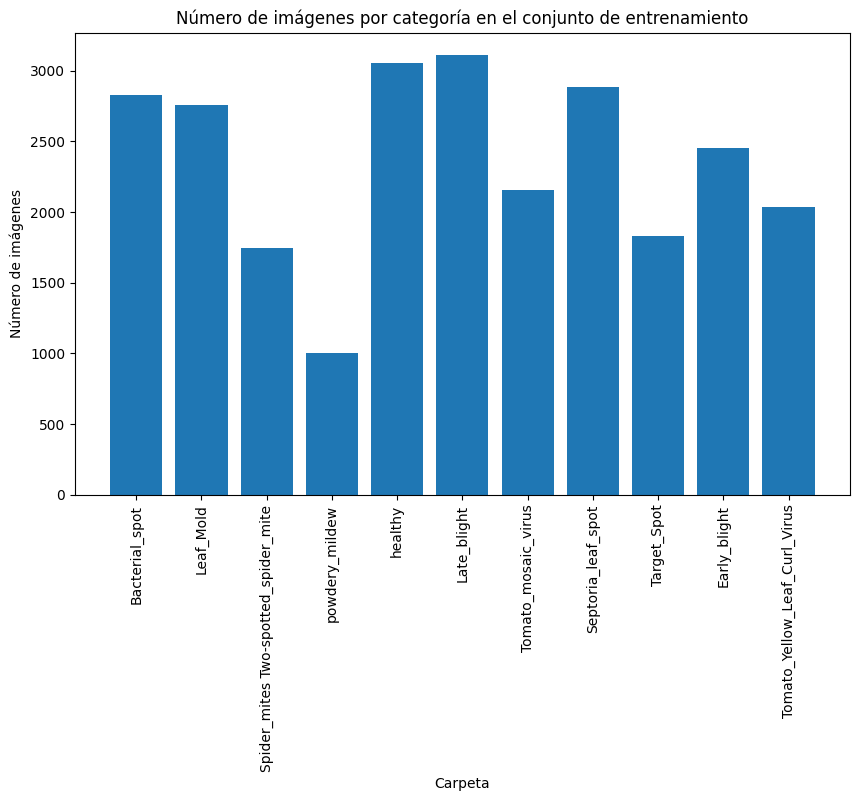

In [ ]:
import os
import matplotlib.pyplot as plt

train_dir = 'my_dataset/train'

disease_folders = os.listdir(train_dir)

num_images = []
labels = []
for folder in disease_folders:
    num_images.append(len(os.listdir(os.path.join(train_dir, folder))))
    labels.append(folder)

plt.figure(figsize=(10, 6))
plt.bar(labels, num_images)
plt.xticks(rotation='vertical')
plt.xlabel('Carpeta')
plt.ylabel('Número de imágenes')
plt.title('Número de imágenes por categoría en el conjunto de entrenamiento')
plt.show()



In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

train_dir = 'my_dataset/train'
valid_dir = 'my_dataset/valid'

def load_images_from_dir(directory):
    images = []
    labels = []
    classes = os.listdir(directory)
    class_to_index = {class_name: i for i, class_name in enumerate(classes)}
    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        images_in_class = os.listdir(class_dir)
        for image_name in images_in_class:
            image_path = os.path.join(class_dir, image_name)
            image = load_img(image_path, target_size=(150, 150))
            image_array = img_to_array(image)
            image_array /= 255.0
            images.append(image_array)
            labels.append(class_to_index[class_name])
    return np.array(images), np.array(labels)

train_images, train_labels = load_images_from_dir(train_dir)
valid_images, valid_labels = load_images_from_dir(valid_dir)

combined_images = np.concatenate((train_images, valid_images), axis=0)
combined_labels = np.concatenate((train_labels, valid_labels), axis=0)

train_ratio = 0.6
valid_ratio = 0.2
test_ratio = 0.2

x_train, x_temp, y_train, y_temp = train_test_split(combined_images, combined_labels, test_size=(1 - train_ratio), random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=test_ratio / (test_ratio + valid_ratio), random_state=42)

del train_images, train_labels, valid_images, valid_labels, combined_images, combined_labels, x_temp, y_temp

Dimensiones del conjunto de entrenamiento: (19520, 150, 150, 3) (19520,)
Dimensiones del conjunto de validación: (6507, 150, 150, 3) (6507,)
Dimensiones del conjunto de prueba: (6507, 150, 150, 3) (6507,)


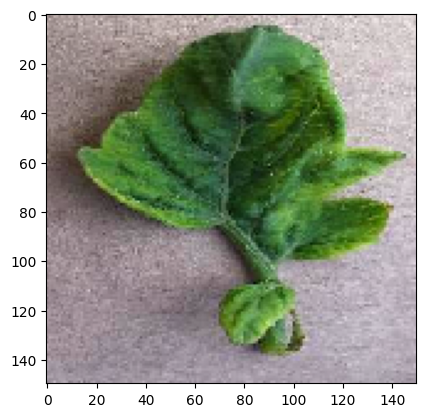

0


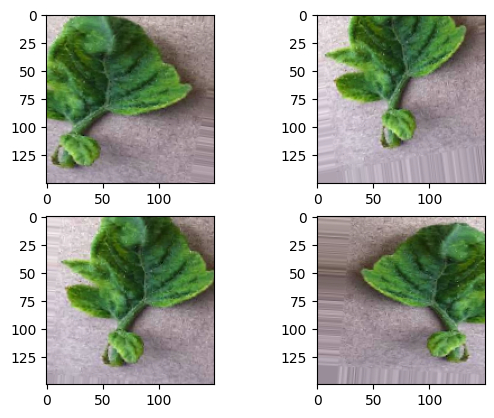

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15, # grados de rotacion aleatoria
    width_shift_range=0.2, # fraccion del total (1) para mover la imagen
    height_shift_range=0.2, # fraccion del total (1) para mover la imagen
    horizontal_flip=True, # girar las imagenes horizontalmente (eje vertical)
    shear_range=0, # deslizamiento
    zoom_range=0.2, # rango de zoom
     fill_mode='nearest', # como rellenar posibles nuevos pixeles
    # channel_shift_range=0.2 # cambios aleatorios en los canales de la imagen
)

from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline
z = np.random.randint(0, len(y_test)-1)
sample = z
plt.imshow(image.array_to_img(x_train[sample]))
plt.show()
print(str(y_train[sample].argmax(axis=0)))

fig, axes = plt.subplots(2,2)
i = 0
for batch in datagen.flow(x_train[sample].reshape((1,150,150,3)),batch_size=1):
    #plt.figure(i)
    axes[i//2,i%2].imshow(image.array_to_img(batch[0]))
    i += 1
    if i == 4:
        break
plt.show()

In [ ]:
import tensorflow as tf
from keras.applications import InceptionResNetV2
from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Crear el modelo base de VGG16 (sin incluir la parte densa superior)
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Congelar las capas convolucionales del modelo base
#for layer in base_model.layers[:-3]:
    #layer.trainable = False

# Crear un modelo secuencial y añadir el modelo base de VGG16
model = Sequential()
model.add(base_model)

# Añadir capas densas adicionales para la clasificación
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(11, activation='softmax'))  # Número de clases en tu conjunto de datos

# Compilar el modelo
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                                 epochs=10, validation_data=(x_valid, y_valid))


[INFO]: Entrenando la red...
Epoch 1/10
610/610 [==============================] - 271s 312ms/step - loss: 1.4922 - accuracy: 0.5587 - val_loss: 0.8086 - val_accuracy: 0.7467
Epoch 2/10
610/610 [==============================] - 186s 305ms/step - loss: 0.6957 - accuracy: 0.7752 - val_loss: 0.5193 - val_accuracy: 0.8320
Epoch 3/10
610/610 [==============================] - 184s 301ms/step - loss: 0.5558 - accuracy: 0.8204 - val_loss: 0.6078 - val_accuracy: 0.8339
Epoch 4/10
610/610 [==============================] - 183s 300ms/step - loss: 0.6279 - accuracy: 0.7983 - val_loss: 2.2535 - val_accuracy: 0.1638
Epoch 5/10
610/610 [==============================] - 173s 284ms/step - loss: 0.5949 - accuracy: 0.8024 - val_loss: 0.9103 - val_accuracy: 0.6707
Epoch 6/10
610/610 [==============================] - 179s 294ms/step - loss: 0.5489 - accuracy: 0.8202 - val_loss: 2.4509 - val_accuracy: 0.1786
Epoch 7/10
610/610 [==============================] - 189s 309ms/step - loss: 0.6391 - accuracy

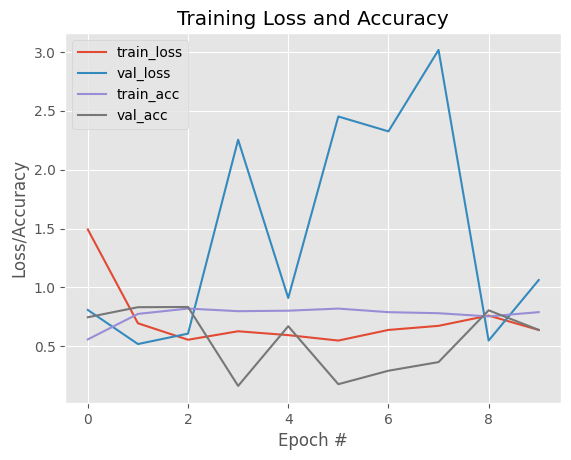

In [ ]:
# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 10), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 10), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 10), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 10), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
evaluaciones = []
# Evaluando el modelo de predicción con las imágenes de test
print("[INFO]: Evaluando red neuronal...")
predictions = model.predict(x_test, batch_size=32)
#print(y_te[0])
#print(predictions[0])
reporte = classification_report(y_test, predictions.argmax(axis=1), output_dict=True)
name= 'InceptionResNetV2'
reporte['modelo'] = name
evaluaciones.append(reporte)
print(classification_report(y_test, predictions.argmax(axis=1)))

[INFO]: Evaluando red neuronal...
204/204 [==============================] - 15s 56ms/step
              precision    recall  f1-score   support

           0       0.92      0.67      0.77       691
           1       0.93      0.69      0.79       728
           2       0.62      0.46      0.53       450
           3       0.72      0.64      0.68       248
           4       0.66      0.57      0.61       814
           5       0.31      0.81      0.45       789
           6       0.94      0.70      0.81       556
           7       0.77      0.67      0.72       706
           8       0.70      0.21      0.33       470
           9       0.84      0.48      0.61       597
          10       0.66      0.92      0.77       458

    accuracy                           0.63      6507
   macro avg       0.73      0.62      0.64      6507
weighted avg       0.73      0.63      0.64      6507



In [ ]:
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Congelar las capas convolucionales del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Crear un modelo secuencial y añadir el modelo base de VGG16
model = Sequential()
model.add(base_model)

# Añadir capas densas adicionales para la clasificación
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(11, activation='softmax'))  # Número de clases en tu conjunto de datos

# Compilar el modelo
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                                 epochs=10, validation_data=(x_valid, y_valid))

[INFO]: Entrenando la red...
Epoch 1/10
610/610 [==============================] - 110s 178ms/step - loss: 1.2888 - accuracy: 0.5675 - val_loss: 0.8475 - val_accuracy: 0.7157
Epoch 2/10
610/610 [==============================] - 103s 169ms/step - loss: 0.9132 - accuracy: 0.6867 - val_loss: 0.7450 - val_accuracy: 0.7397
Epoch 3/10
610/610 [==============================] - 105s 172ms/step - loss: 0.8232 - accuracy: 0.7123 - val_loss: 0.6974 - val_accuracy: 0.7603
Epoch 4/10
610/610 [==============================] - 104s 170ms/step - loss: 0.7584 - accuracy: 0.7366 - val_loss: 0.6332 - val_accuracy: 0.7847
Epoch 5/10
610/610 [==============================] - 105s 172ms/step - loss: 0.7266 - accuracy: 0.7451 - val_loss: 0.6506 - val_accuracy: 0.7779
Epoch 6/10
610/610 [==============================] - 105s 171ms/step - loss: 0.6863 - accuracy: 0.7605 - val_loss: 0.6405 - val_accuracy: 0.7793
Epoch 7/10
610/610 [==============================] - 105s 172ms/step - loss: 0.6745 - accuracy

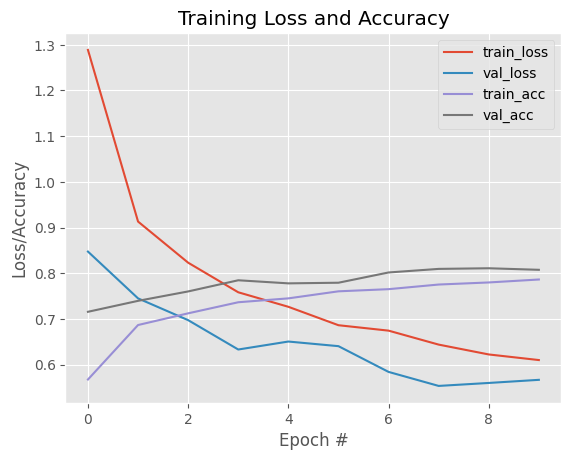

In [ ]:
# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 10), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 10), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 10), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 10), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# Evaluando el modelo de predicción con las imágenes de test
print("[INFO]: Evaluando red neuronal...")
predictions = model.predict(x_test, batch_size=32)
#print(y_te[0])
#print(predictions[0])
reporte = classification_report(y_test, predictions.argmax(axis=1), output_dict=True)
name= 'VGG16'
reporte['modelo'] = name
evaluaciones.append(reporte)
print(classification_report(y_test, predictions.argmax(axis=1)))

[INFO]: Evaluando red neuronal...
204/204 [==============================] - 12s 56ms/step
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       691
           1       0.81      0.77      0.79       728
           2       0.69      0.92      0.79       450
           3       0.76      0.81      0.78       248
           4       0.89      0.96      0.92       814
           5       0.72      0.83      0.77       789
           6       0.92      0.92      0.92       556
           7       0.69      0.77      0.73       706
           8       0.79      0.70      0.74       470
           9       0.88      0.54      0.67       597
          10       0.97      0.83      0.90       458

    accuracy                           0.81      6507
   macro avg       0.82      0.80      0.80      6507
weighted avg       0.82      0.81      0.80      6507



In [ ]:
from keras.applications import MobileNet

# Crear el modelo base de VGG16 (sin incluir la parte densa superior)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Congelar las capas convolucionales del modelo base
#for layer in base_model.layers[:-3]:
    #layer.trainable = False

# Crear un modelo secuencial y añadir el modelo base de VGG16
model = Sequential()
model.add(base_model)

# Añadir capas densas adicionales para la clasificación
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(11, activation='softmax'))  # Número de clases en tu conjunto de datos

# Compilar el modelo
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                                 epochs=10, validation_data=(x_valid, y_valid))

[INFO]: Entrenando la red...
Epoch 1/10
610/610 [==============================] - 119s 174ms/step - loss: 1.9170 - accuracy: 0.3863 - val_loss: 1.5965 - val_accuracy: 0.5579
Epoch 2/10
610/610 [==============================] - 103s 169ms/step - loss: 1.2217 - accuracy: 0.5980 - val_loss: 2.5978 - val_accuracy: 0.5549
Epoch 3/10
610/610 [==============================] - 102s 168ms/step - loss: 0.8305 - accuracy: 0.7402 - val_loss: 0.6906 - val_accuracy: 0.8076
Epoch 4/10
610/610 [==============================] - 102s 167ms/step - loss: 0.6843 - accuracy: 0.7933 - val_loss: 0.5159 - val_accuracy: 0.8300
Epoch 5/10
610/610 [==============================] - 103s 168ms/step - loss: 0.5833 - accuracy: 0.8249 - val_loss: 0.8121 - val_accuracy: 0.8057
Epoch 6/10
610/610 [==============================] - 103s 168ms/step - loss: 0.5055 - accuracy: 0.8478 - val_loss: 0.4903 - val_accuracy: 0.8505
Epoch 7/10
610/610 [==============================] - 102s 167ms/step - loss: 0.4459 - accuracy

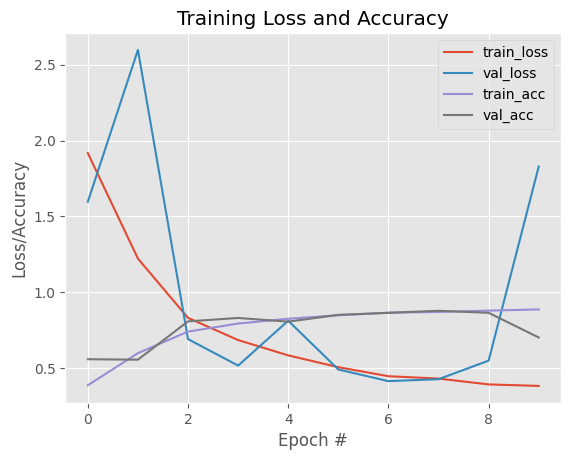

In [ ]:
# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 10), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 10), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 10), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 10), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# Evaluando el modelo de predicción con las imágenes de test
print("[INFO]: Evaluando red neuronal...")
predictions = model.predict(x_test, batch_size=32)
#print(y_te[0])
#print(predictions[0])
reporte = classification_report(y_test, predictions.argmax(axis=1), output_dict=True)
name= 'MobileNet'
reporte['modelo'] = name
evaluaciones.append(reporte)
print(classification_report(y_test, predictions.argmax(axis=1)))

[INFO]: Evaluando red neuronal...
204/204 [==============================] - 6s 27ms/step
              precision    recall  f1-score   support

           0       0.71      0.61      0.65       691
           1       0.77      0.70      0.74       728
           2       0.94      0.36      0.53       450
           3       0.92      0.59      0.72       248
           4       0.53      1.00      0.69       814
           5       0.70      0.86      0.77       789
           6       0.98      0.79      0.88       556
           7       0.81      0.61      0.69       706
           8       0.46      0.70      0.55       470
           9       0.94      0.63      0.75       597
          10       0.90      0.64      0.75       458

    accuracy                           0.71      6507
   macro avg       0.79      0.68      0.70      6507
weighted avg       0.77      0.71      0.71      6507



In [ ]:
df_evaluaciones = pd.DataFrame(evaluaciones)
df_evaluaciones.to_excel('evaluaciones_modelos.xlsx', index=False)
from google.colab import files

# Descargar el archivo Excel
files.download('evaluaciones_modelos.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_reestructurado = pd.DataFrame()

# Copiando la columna de modelo
df_reestructurado['Modelo'] = df_evaluaciones['modelo']

# Iterando sobre las columnas y filas para extraer las métricas
for col in range(11):  # Rango de columnas de 0 a 10
    precision_values = []
    recall_values = []
    f1_score_values = []
    support_values = []
    for index, row in df_evaluaciones.iterrows():
        metrics = row[col]  # Métricas de la celda
        if isinstance(metrics, dict):  # Verifica si la celda no es NaN
            precision_values.append(metrics['precision'])
            recall_values.append(metrics['recall'])
            f1_score_values.append(metrics['f1-score'])
            support_values.append(metrics['support'])
        else:  # Si es NaN, añade NaN a todas las métricas
            precision_values.append(np.nan)
            recall_values.append(np.nan)
            f1_score_values.append(np.nan)
            support_values.append(np.nan)

    df_reestructurado[f'{col}_precision'] = precision_values
    df_reestructurado[f'{col}_recall'] = recall_values
    df_reestructurado[f'{col}_f1-score'] = f1_score_values
    df_reestructurado[f'{col}_support'] = support_values

# Copiando las columnas 'accuracy', 'macro avg' y 'weighted avg'
for col in ['accuracy', 'macro avg', 'weighted avg']:
    precision_values = []
    recall_values = []
    f1_score_values = []
    support_values = []
    for index, row in df_evaluaciones.iterrows():
        metrics = row[col]  # Métricas de la celda
        if isinstance(metrics, dict):  # Verifica si la celda no es NaN
            precision_values.append(metrics['precision'])
            recall_values.append(metrics['recall'])
            f1_score_values.append(metrics['f1-score'])
            support_values.append(metrics['support'])
        else:  # Si es NaN, añade NaN a todas las métricas
            precision_values.append(np.nan)
            recall_values.append(np.nan)
            f1_score_values.append(np.nan)
            support_values.append(np.nan)

    df_reestructurado[f'{col}_precision'] = precision_values
    df_reestructurado[f'{col}_recall'] = recall_values
    df_reestructurado[f'{col}_f1-score'] = f1_score_values
    df_reestructurado[f'{col}_support'] = support_values

# Mostrando el dataframe reestructurado
print(df_reestructurado)

              Modelo  0_precision  0_recall  0_f1-score  0_support  \
0  InceptionResNetV2     0.920319  0.668596    0.774518        691   
1              VGG16     0.857143  0.798842    0.826966        691   
2          MobileNet     0.708263  0.607815    0.654206        691   

   1_precision  1_recall  1_f1-score  1_support  2_precision  ...  \
0     0.925788  0.685440    0.787687        728     0.617211  ...   
1     0.813584  0.773352    0.792958        728     0.690000  ...   
2     0.771903  0.701923    0.735252        728     0.942529  ...   

   accuracy_f1-score  accuracy_support  macro avg_precision  macro avg_recall  \
0                NaN               NaN             0.734224          0.620385   
1                NaN               NaN             0.815861          0.803931   
2                NaN               NaN             0.787602          0.680192   

   macro avg_f1-score  macro avg_support  weighted avg_precision  \
0            0.642061               6507         

In [ ]:

df_reestructurado.to_excel('evaluaciones_modelos.xlsx', index=False)
from google.colab import files

# Descargar el archivo Excel
files.download('evaluaciones_modelos.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>